In [1]:
import pyodbc
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

Importing plotly failed. Interactive plots will not work.


# Read data

In [3]:
cusor = cnxn.cursor()

In [4]:
sql = '''
    select * from General."Report Sources"."Return to Work"."Covid 19 Update"
'''

In [5]:
cusor.execute(sql)

In [6]:
response = cusor.fetchall()

In [7]:
data = pd.DataFrame.from_records(response, 
                                 columns=['state_fips', 'state_name', 
                                          'county_name', 'area_name', 'lat', 
                                          'long', 'date', 'cases', 'deaths',
                                         'county_fips','id2','population_estimate_2018'])

In [8]:
data.head()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018
0,01,Alabama,Franklin County,,34.4419892,-87.8428144,2020-03-25,2,0,1059,1059,31363
1,01,Alabama,Franklin County,,34.4419892,-87.8428144,2020-03-26,3,0,1059,1059,31363
2,01,Alabama,Franklin County,,34.4419892,-87.8428144,2020-03-27,3,0,1059,1059,31363
3,01,Alabama,Franklin County,,34.4419892,-87.8428144,2020-03-28,3,0,1059,1059,31363
4,01,Alabama,Franklin County,,34.4419892,-87.8428144,2020-03-29,3,0,1059,1059,31363


In [9]:
# Remove leading and trailing white spaces
data.replace('^\s+', '', regex=True, inplace=True)
data.replace('\s+$', '', regex=True, inplace=True)

In [10]:
data['cases'] = data['cases'].astype(int)
data['population_estimate_2018'] = data['population_estimate_2018'].astype(int)
data['date'] = pd.to_datetime(data['date'])

# County name is not unique - create State-County name

In [11]:
data['state_county'] = data['state_name'] + ', ' + data['county_name']

In [12]:
data['county_name'].unique()

array(['Franklin County', 'Geneva County', 'Greene County', ...,
       'Waupaca County', 'Waushara County', 'Converse County'],
      dtype=object)

In [13]:
data['state_county'].nunique(), data['county_name'].nunique()

(3176, 1930)

In [14]:
print(data['cases'].isna().sum(), data['date'].isna().sum())

0 0


## Use recent 10 cases to calculate percentage change in cases

In [15]:
# lambda x: x[-10:].pct_change().mean()*100)
pct_change = data.groupby('state_county').apply(
    lambda x: x['cases'][-10:].pct_change().mean()*100).reset_index()
pct_change.columns = ['state_county', 'change_trend']

In [16]:
pct_change.head()

,state_county,change_trend
0,"Alabama, Autauga County",2.223732
1,"Alabama, Baldwin County",5.793953
2,"Alabama, Barbour County",2.262622
3,"Alabama, Bibb County",2.537120
4,"Alabama, Blount County",5.234042


# Define growth

In [17]:
def growth(x):
    if x > 1 and x <=5:
        return "growth"
    elif x >5 and x<10:
        return "high growth"
    elif x>=10:
        return "very high growth"
    elif x>=-1 and x<=1:
        return "leveling off"
    else:
        return "cases decreasing"

In [18]:
pct_change['trend'] = pct_change['change_trend'].apply(growth)

In [19]:
pct_change.trend.value_counts()

growth              2028
leveling off         678
high growth          361
very high growth     100
cases decreasing       9
Name: trend, dtype: int64

In [20]:
prev = len(data)
data = data.merge(pct_change, how='left')
assert(prev == len(data))

In [21]:
data.tail()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend
362644,56,Wyoming,Fremont County,,43.054831,-108.6089349,2020-07-11,384,9,56013,56013,39531,"Wyoming, Fremont County",1.069512,growth
362645,56,Wyoming,Fremont County,,43.054831,-108.6089349,2020-07-12,386,9,56013,56013,39531,"Wyoming, Fremont County",1.069512,growth
362646,56,Wyoming,Fremont County,,43.054831,-108.6089349,2020-07-13,387,9,56013,56013,39531,"Wyoming, Fremont County",1.069512,growth
362647,56,Wyoming,Fremont County,,43.054831,-108.6089349,2020-07-14,397,9,56013,56013,39531,"Wyoming, Fremont County",1.069512,growth
362648,56,Wyoming,Fremont County,,43.054831,-108.6089349,2020-07-15,407,9,56013,56013,39531,"Wyoming, Fremont County",1.069512,growth


# Calculate current cases per hundred thousand population

In [22]:
# number of cases per hundred thousand population
data['cases_per_hud_thousand'] = data['cases']/data['population_estimate_2018'] *100000

In [23]:
data.head()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend,cases_per_hud_thousand
0,01,Alabama,Franklin County,,34.4419892,-87.8428144,2020-03-25,2,0,1059,1059,31363,"Alabama, Franklin County",-10.335184,cases decreasing,6.376941
1,01,Alabama,Franklin County,,34.4419892,-87.8428144,2020-03-26,3,0,1059,1059,31363,"Alabama, Franklin County",-10.335184,cases decreasing,9.565411
2,01,Alabama,Franklin County,,34.4419892,-87.8428144,2020-03-27,3,0,1059,1059,31363,"Alabama, Franklin County",-10.335184,cases decreasing,9.565411
3,01,Alabama,Franklin County,,34.4419892,-87.8428144,2020-03-28,3,0,1059,1059,31363,"Alabama, Franklin County",-10.335184,cases decreasing,9.565411
4,01,Alabama,Franklin County,,34.4419892,-87.8428144,2020-03-29,3,0,1059,1059,31363,"Alabama, Franklin County",-10.335184,cases decreasing,9.565411


In [24]:
# taking the mean of last two cases to calculate current cases per hundred thousand population
cases_thou = data.groupby('state_county').apply(
    lambda x: x['cases_per_hud_thousand'][-2:].mean()).reset_index()

In [25]:
cases_thou.columns = ['state_county', 'current_cases_per_hund_thou']

In [26]:
quartiles = cases_thou['current_cases_per_hund_thou'].quantile([0.25, 0.75], interpolation='nearest')
q1 = list(quartiles)[0]
q2 = list(quartiles)[1]
med = cases_thou['current_cases_per_hund_thou'].median()

In [27]:
# defining high and low cases based on the quartiles
def cases_thousands(x):
    if x > q2:
        return 'very high cases'
    elif x>med and x<q2:
        return 'high cases'
    elif x<med and x>q1:
        return 'relatively low cases'
    else:
        return 'relatively very low cases'

In [28]:
cases_thou['current_number_cases_category'] = cases_thou['current_cases_per_hund_thou'].apply(cases_thousands)

In [29]:
cases_thou.head()

,state_county,current_cases_per_hund_thou,current_number_cases_category
0,"Alabama, Autauga County",1642.056798,very high cases
1,"Alabama, Baldwin County",1140.710570,very high cases
2,"Alabama, Barbour County",2156.263816,very high cases
3,"Alabama, Bibb County",1321.428571,very high cases
4,"Alabama, Blount County",1037.344398,high cases


In [30]:
cases_thou.current_number_cases_category.value_counts()

relatively very low cases    796
very high cases              794
relatively low cases         793
high cases                   793
Name: current_number_cases_category, dtype: int64

In [31]:
cases_thou[cases_thou.current_number_cases_category=='relatively very low cases'].head()

,state_county,current_cases_per_hund_thou,current_number_cases_category
29,"Alabama, Franklin County",3.188470,relatively very low cases
67,"Alaska, Aleutians East Borough",85.348506,relatively very low cases
70,"Alaska, Bethel Census Area",107.048748,relatively very low cases
72,"Alaska, Denali Borough",145.701797,relatively very low cases
79,"Alaska, Kodiak Island Borough",104.908205,relatively very low cases


In [32]:
prev = len(data)
data = data.merge(cases_thou, how='left')
assert(prev == len(data))

In [33]:
data.tail()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend,cases_per_hud_thousand,current_cases_per_hund_thou,current_number_cases_category
362644,56,Wyoming,Fremont County,,43.054831,-108.6089349,2020-07-11,384,9,56013,56013,39531,"Wyoming, Fremont County",1.069512,growth,971.389542,1016.923427,high cases
362645,56,Wyoming,Fremont County,,43.054831,-108.6089349,2020-07-12,386,9,56013,56013,39531,"Wyoming, Fremont County",1.069512,growth,976.448863,1016.923427,high cases
362646,56,Wyoming,Fremont County,,43.054831,-108.6089349,2020-07-13,387,9,56013,56013,39531,"Wyoming, Fremont County",1.069512,growth,978.978523,1016.923427,high cases
362647,56,Wyoming,Fremont County,,43.054831,-108.6089349,2020-07-14,397,9,56013,56013,39531,"Wyoming, Fremont County",1.069512,growth,1004.275126,1016.923427,high cases
362648,56,Wyoming,Fremont County,,43.054831,-108.6089349,2020-07-15,407,9,56013,56013,39531,"Wyoming, Fremont County",1.069512,growth,1029.571729,1016.923427,high cases


# Shuffle counties

In [34]:
all_state_county = list(data['state_county'].unique())

In [35]:
import random
random.shuffle(all_state_county)

In [36]:
all_state_county = all_state_county[0:20]

In [59]:
all_state_county = ['Texas, Dimmit County',
 'New Mexico, Luna County',
 'New Jersey, Hunterdon County',
 'California, San Luis Obispo County',
 'Nebraska, Otoe County',
 'Nevada, Washoe County',
 'Texas, Archer County',
 'Texas, Deaf Smith County',
 'Georgia, Jasper County',
 'Michigan, Isabella County',
 'Georgia, Jones County',
 'Florida, Calhoun County',
 'Nebraska, Valley County',
 'West Virginia, Boone County',
 'North Carolina, Craven County',
 'Minnesota, Redwood County',
 'Michigan, Alpena County',
 'Arizona, Pima County',
 'Iowa, Butler County',
 'Michigan, Calhoun County']

# Check time series with one county

In [60]:
ts = data[data['state_county']==all_state_county[0]].copy()

In [61]:
county_name =  all_state_county[9]
ts = data[data['state_county']==county_name].copy()
ts = ts[['date', 'cases']].copy()
ts.date = pd.to_datetime(ts.date)
#ts = ts.set_index(['date'])
ts.cases = ts.cases.astype(int)

In [62]:
all_state_county[9]

'Michigan, Isabella County'

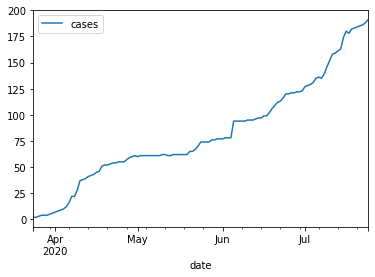

In [63]:
ts_check = ts.set_index('date')
ts_check.plot()

In [64]:
ts.tail()

,date,cases
153321,2020-07-20,184
153322,2020-07-21,185
153323,2020-07-22,186
153324,2020-07-23,188
153325,2020-07-24,191


# Prophet model

In [65]:
# Create prophet model for each county and use date only after '2020-06-01'
df = pd.DataFrame()
for ii in all_state_county:
    ts = data[data['state_county']==ii].copy()
    # use only date after 2020-06-01
    ts = ts[ts.date >=pd.to_datetime('2020-06-01')].copy()
    capacity = ts.population_estimate_2018.mean()/2.# carrying capavity
    int_df = ts.copy()
    ts = ts[:-10].copy()
    # check the baseline of last value moving forward
    last_val_forward = ts['cases'][-1:].values[0]  
    ts = ts[['date', 'cases']].copy()
    ts.date = pd.to_datetime(ts.date)
    ts.columns = ['ds', 'y']
    ts['cap'] = capacity
    model = Prophet(growth = 'logistic')  # can also specify seasonality-multplicative in the model
    model.fit(ts)
    future = model.make_future_dataframe(periods=10,freq = 'D')
    future['cap'] = capacity
    forecast = model.predict(future)
    fcast = forecast[['ds', 'yhat']].copy()
    fcast.columns = ['date','predicted_cases']
    int_df['date'] = list(fcast.date)
    int_df['predicted_cases'] = list(fcast.predicted_cases)
    acc = 100.-abs(int_df['cases'][-10:]-int_df['predicted_cases'][-10:])/(int_df['cases'][-10:])*100
    int_df['accuracy'] = acc.mean()
    int_df['baseline_accuracy'] = 100.-abs(int_df['cases'][-10:]-last_val_forward)/(int_df['cases'][-10:])*100
    df = pd.concat([df,int_df])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [66]:
len(int_df)

54

In [67]:
int_df.head()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,...,population_estimate_2018,state_county,change_trend,trend,cases_per_hud_thousand,current_cases_per_hund_thou,current_number_cases_category,predicted_cases,accuracy,baseline_accuracy
143796,26,Michigan,Calhoun County,,42.2429896,-85.0123853,2020-06-01,372,22,26025,...,134487,"Michigan, Calhoun County",0.935504,leveling off,276.606661,507.483995,relatively low cases,376.270073,99.222938,NaN
143797,26,Michigan,Calhoun County,,42.2429896,-85.0123853,2020-06-02,386,23,26025,...,134487,"Michigan, Calhoun County",0.935504,leveling off,287.016589,507.483995,relatively low cases,389.548449,99.222938,NaN
143798,26,Michigan,Calhoun County,,42.2429896,-85.0123853,2020-06-03,392,23,26025,...,134487,"Michigan, Calhoun County",0.935504,leveling off,291.477987,507.483995,relatively low cases,401.293538,99.222938,NaN
143799,26,Michigan,Calhoun County,,42.2429896,-85.0123853,2020-06-04,398,23,26025,...,134487,"Michigan, Calhoun County",0.935504,leveling off,295.939384,507.483995,relatively low cases,414.863058,99.222938,NaN
143800,26,Michigan,Calhoun County,,42.2429896,-85.0123853,2020-06-05,454,25,26025,...,134487,"Michigan, Calhoun County",0.935504,leveling off,337.579097,507.483995,relatively low cases,435.389303,99.222938,NaN


# Individually check all cases

In [68]:
number_ = 19

In [69]:
check = df[df['state_county'] == 'West Virginia, Boone County'][['date', 'cases', 'predicted_cases']]

In [70]:
all_state_county[number_]

'Michigan, Calhoun County'

In [71]:
len(check)

54

In [72]:
check.tail(10)

,date,cases,predicted_cases
348587,2020-07-15,46,33.059674
348588,2020-07-16,50,34.260870
348589,2020-07-17,53,35.637923
348590,2020-07-18,57,36.357771
348591,2020-07-19,61,37.420630
348592,2020-07-20,58,37.840758
348593,2020-07-21,59,39.866034
348594,2020-07-22,63,39.483045
348595,2020-07-23,64,40.845830
348596,2020-07-24,69,42.388508


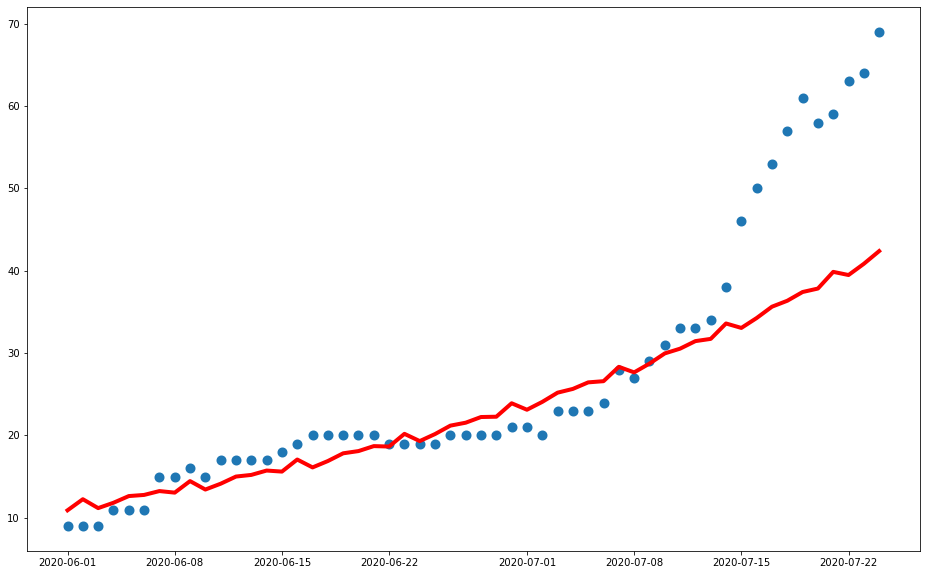

In [73]:
plt.figure (figsize=(16,10))
plt.scatter(check['date'], check['cases'], lw=4)
plt.plot(check['date'], check['predicted_cases'], color='r', lw=4)

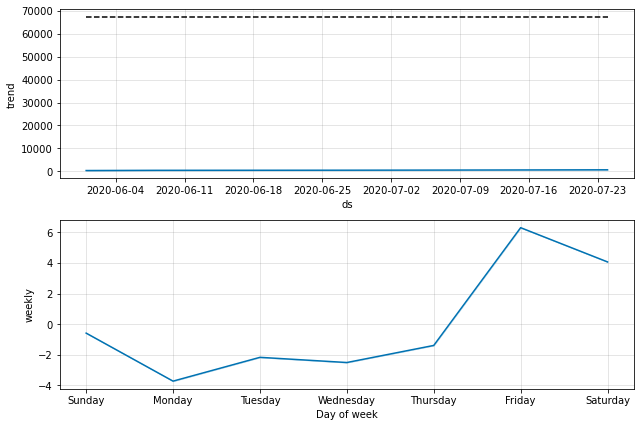

In [74]:
fig = model.plot_components(forecast)

In [75]:
df[df['state_county'] == all_state_county[number_]].head()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,...,population_estimate_2018,state_county,change_trend,trend,cases_per_hud_thousand,current_cases_per_hund_thou,current_number_cases_category,predicted_cases,accuracy,baseline_accuracy
143796,26,Michigan,Calhoun County,,42.2429896,-85.0123853,2020-06-01,372,22,26025,...,134487,"Michigan, Calhoun County",0.935504,leveling off,276.606661,507.483995,relatively low cases,376.270073,99.222938,NaN
143797,26,Michigan,Calhoun County,,42.2429896,-85.0123853,2020-06-02,386,23,26025,...,134487,"Michigan, Calhoun County",0.935504,leveling off,287.016589,507.483995,relatively low cases,389.548449,99.222938,NaN
143798,26,Michigan,Calhoun County,,42.2429896,-85.0123853,2020-06-03,392,23,26025,...,134487,"Michigan, Calhoun County",0.935504,leveling off,291.477987,507.483995,relatively low cases,401.293538,99.222938,NaN
143799,26,Michigan,Calhoun County,,42.2429896,-85.0123853,2020-06-04,398,23,26025,...,134487,"Michigan, Calhoun County",0.935504,leveling off,295.939384,507.483995,relatively low cases,414.863058,99.222938,NaN
143800,26,Michigan,Calhoun County,,42.2429896,-85.0123853,2020-06-05,454,25,26025,...,134487,"Michigan, Calhoun County",0.935504,leveling off,337.579097,507.483995,relatively low cases,435.389303,99.222938,NaN


In [76]:
acc_check = df.groupby('state_county')[['accuracy', 'baseline_accuracy']].mean()

In [77]:
acc_check

,accuracy,baseline_accuracy
state_county,,
"Arizona, Pima County",94.218270,89.998464
"California, San Luis Obispo County",97.304037,83.915593
"Florida, Calhoun County",74.927075,80.004199
"Georgia, Jasper County",97.438456,88.760614
"Georgia, Jones County",92.252858,81.807923
"Iowa, Butler County",92.719754,85.126662
"Michigan, Alpena County",98.669563,98.639355
"Michigan, Calhoun County",99.222938,94.501272
"Michigan, Isabella County",97.154920,89.081014


In [78]:
acc_check['accuracy'].mean()

89.12544804068702

In [79]:
acc_check['baseline_accuracy'].mean()

87.65619835162684